In [ ]:
# Will be three modeling steps:
# Model inputs: State budget, max travel distance
# 1. Demand maximation (s/t cost, distance), gives # people we can route to a hub
# 2. Aggregate distance minimization
# 3. Use (x) * # people, (y) * distance for cost minimization

In [128]:
import os
from datetime import datetime
import pandas as pd
import numpy as np
from pyomo.environ import *
import pyomo.opt as pyopt

import geopandas as gpd
import pandas as pd
import numpy as np
from statistics import mean

import itertools

import matplotlib.pyplot as plt
import matplotlib
import plotly.express as px
import shapely
import folium
import plotly.graph_objects as go # or plotly.express as px
import seaborn as sns

import solve_models_functions_cmm 
from solve_models_functions_cmm import *

from data_cleaning_cmm import (blockgroup_pop_dict, blockgroup_walkability_dict, blockgroup_no_car_pop_dict, bg_ces_dict,
                               dist_to_site_contra_costa_df, dist_to_site_contra_costa_dict,
                               dist_to_site_contra_costa_walk_df, dist_to_site_contra_costa_walk_dict,
                               dist_to_site_richmond_df, dist_to_site_richmond_dict,
                               dist_to_site_richmond_walk_df, dist_to_site_richmond_walk_dict,
                               dist_to_site_wilmington_df, dist_to_site_wilmington_dict,
                               dist_to_site_wilmington_walk_df, dist_to_site_wilmington_walk_dict,
                           county_prop_ealp_dict, site_kw_occ_dict,
                           site_sqft_dict, site_cost_dict)

In [108]:
# Base model
import deployment_models_cmm
import importlib
importlib.reload(deployment_models_cmm)
importlib.reload(solve_models_functions_cmm)

# To run with expected number of people without a car, change blockgroup_pop_dict to blockgroup_no_car_pop_dict
model_base, bg_with_no_hub = deployment_models_cmm.build_base_model(site_cost_dict, site_kw_occ_dict, blockgroup_pop_dict, bg_ces_dict, blockgroup_walkability_dict, dist_to_site_contra_costa_df)

In [109]:
# Load sites data
ca_albers_nad83 = 'NAD_1983_California_Teale_Albers_FtUS'
nad83 = 'EPSG:4629'
wgs84 = 'EPSG:4326'

# Building candidate sites GeoDataFrame
sites_path = os.path.join(os.getcwd(), 'data', 'candidate_site_campuses_2021-11-17', 'candidate_sites_campuses.csv')
sites_df_raw = pd.read_csv(sites_path)
sites_df_raw = sites_df_raw.loc[sites_df_raw['cat_site'] != 'X', ['id_site', 'cat_site', 'SQFT_ROOF', 'LON', 'LAT']]
sites_geom = gpd.points_from_xy(sites_df_raw.LON, sites_df_raw.LAT, crs = nad83)
sites_gdf = gpd.GeoDataFrame(sites_df_raw, geometry = sites_geom, crs = nad83)



In [110]:
# apply cost minimization combined function

max_cost = 5000000 # $ that we can spend on hubs
prop_served_scale_factor = .75
agg_dist_scale_factor = 1.25

var_hub_yn_contra_costa_walkability, cost_contra_costa_walkability = model_func_walkability(dist_to_site_contra_costa_walk_df, max_cost, prop_served_scale_factor, agg_dist_scale_factor)
var_hub_yn_wilmington_walkability, cost_wilmington_walkability = model_func_walkability(dist_to_site_wilmington_walk_df, max_cost, prop_served_scale_factor, agg_dist_scale_factor)
var_hub_yn_richmond_walkability, cost_richmond_walkability = model_func_walkability(dist_to_site_richmond_walk_df, max_cost, prop_served_scale_factor, agg_dist_scale_factor)

var_hub_yn_contra_costa_drive, cost_contra_costa_drive = model_func(dist_to_site_contra_costa_df, max_cost, prop_served_scale_factor, agg_dist_scale_factor)
var_hub_yn_contra_costa_walk, cost_contra_costa_walk = model_func(dist_to_site_contra_costa_walk_df, max_cost, prop_served_scale_factor, agg_dist_scale_factor)

var_hub_yn_wilmington_drive, cost_wilmington_drive = model_func(dist_to_site_wilmington_df, max_cost, prop_served_scale_factor, agg_dist_scale_factor)
var_hub_yn_wilmington_walk, cost_wilmington_walk = model_func(dist_to_site_wilmington_walk_df, max_cost, prop_served_scale_factor, agg_dist_scale_factor)

var_hub_yn_richmond_drive, cost_richmond_drive = model_func(dist_to_site_richmond_df, max_cost, prop_served_scale_factor, agg_dist_scale_factor)
var_hub_yn_richmond_walk, cost_richmond_walk = model_func(dist_to_site_richmond_walk_df, max_cost, prop_served_scale_factor, agg_dist_scale_factor)

var_hub_yn_contra_costa_drive_ces, cost_contra_costa_drive_ces = model_func_ces(dist_to_site_contra_costa_df, max_cost, prop_served_scale_factor, agg_dist_scale_factor)
var_hub_yn_contra_costa_walk_ces, cost_contra_costa_walk_ces = model_func_ces(dist_to_site_contra_costa_walk_df, max_cost, prop_served_scale_factor, agg_dist_scale_factor)

var_hub_yn_wilmington_drive_ces, cost_wilmington_drive_ces = model_func_ces(dist_to_site_wilmington_df, max_cost, prop_served_scale_factor, agg_dist_scale_factor)
var_hub_yn_wilmington_walk_ces, cost_wilmington_walk_ces = model_func_ces(dist_to_site_wilmington_walk_df, max_cost, prop_served_scale_factor, agg_dist_scale_factor)

#var_hub_yn_richmond_drive_ces, cost_richmond_drive_ces = model_func_ces(dist_to_site_richmond_df, max_cost, prop_served_scale_factor, agg_dist_scale_factor)
#var_hub_yn_richmond_walk_ces, cost_richmond_walk_ces = model_func_ces(dist_to_site_richmond_walk_df, max_cost, prop_served_scale_factor, agg_dist_scale_factor)



In [121]:
map_hubs(var_hub_yn_contra_costa_walk, sites_gdf)

In [122]:
map_hubs(var_hub_yn_contra_costa_walkability, sites_gdf)

In [15]:
map_hubs(var_hub_yn_wilmington_walk, sites_gdf)

In [16]:
map_hubs(var_hub_yn_wilmington_walkability, sites_gdf)

In [9]:
map_hubs(var_hub_yn_richmond_walk, sites_gdf)

In [10]:
map_hubs(var_hub_yn_richmond_walkability, sites_gdf)

In [140]:
# plot characteristics of people who can get to a hub in Contra Costa via walking vs can't
hubs = var_hub_yn_contra_costa_walk.loc[var_hub_yn_contra_costa_walk['BUILT'] == 1].index
hubs_ces = var_hub_yn_contra_costa_walk_ces.loc[var_hub_yn_contra_costa_walk_ces['BUILT'] == 1].index
hubs_walkability = var_hub_yn_contra_costa_walkability.loc[var_hub_yn_contra_costa_walkability['BUILT'] == 1].index

#hubs = var_hub_yn_richmond_walk.loc[var_hub_yn_richmond_walk['BUILT'] == 1].index
#hubs_ces = var_hub_yn_richmond_walk_ces.loc[var_hub_yn_richmond_walk_ces['BUILT'] == 1].index
#hubs_walkability = var_hub_yn_richmond_walkability.loc[var_hub_yn_richmond_walkability['BUILT'] == 1].index

# create hubs gdf with built hubs only
hubs_gdf = sites_gdf.loc[sites_gdf['id_site'].isin(list(hubs))]
hubs_ces_gdf = sites_gdf.loc[sites_gdf['id_site'].isin(list(hubs_ces))]
hubs_walkability_gdf = sites_gdf.loc[sites_gdf['id_site'].isin(list(hubs_walkability))]

# Compare characteristics of people in block groups that matched to a hub
# vs. people in block groups that did not
bg_ces_df = pd.read_csv('data/bg_ca_19/bg19_ces_indicators.csv')
# Potential variables: ['PCT_LESSHS', 'PCT_UNEMP', 'PCT_RENT', 
# 'PCT_LINGISO', 'PCT_POV', 'RATE_ASTH', 'RATE_LBW', 'RATE_CVD']

max_distance = 1.5

no = solve_models_functions_cmm.no_distance(hubs, dist_to_site_contra_costa_walk_df, max_distance)
yes = solve_models_functions_cmm.yes_distance(hubs, dist_to_site_contra_costa_walk_df, max_distance)

no_ces = solve_models_functions_cmm.no_distance(hubs_ces, dist_to_site_contra_costa_walk_df, max_distance)
yes_ces = solve_models_functions_cmm.yes_distance(hubs_ces, dist_to_site_contra_costa_walk_df, max_distance)

no_walkability = solve_models_functions_cmm.no_distance(hubs_walkability, dist_to_site_contra_costa_walk_df, max_distance)
yes_walkability = solve_models_functions_cmm.yes_distance(hubs_walkability, dist_to_site_contra_costa_walk_df, max_distance)

#no = solve_models_functions_cmm.no_distance(hubs, dist_to_site_richmond_walk_df, max_distance)
#yes = solve_models_functions_cmm.yes_distance(hubs, dist_to_site_richmond_walk_df, max_distance)

#no_walkability = solve_models_functions_cmm.no_distance(hubs_walkability, dist_to_site_richmond_walk_df, max_distance)
#yes_walkability = solve_models_functions_cmm.yes_distance(hubs_walkability, dist_to_site_richmond_walk_df, max_distance)


plt.rcParams['figure.figsize'] = [25, 4]
font = {'weight' : 'normal',
        'size'   : 15}

matplotlib.rc('font', **font)

In [150]:
def boxplot_characteristics(list_bg_ids, data, group_names, characteristic):
    list_x = [[]]*len(list_bg_ids)
    # create x values for plot
    for i in np.arange(len(list_bg_ids)):
        list_x[i] = (retrieve_characteristics(list_bg_ids[i], data, characteristic))

    plt.boxplot(list_x, labels = group_names);
    plt.ylabel(characteristic)
    return(plt)

In [198]:
def histogram_characteristics2(list_bg_ids, data, group_names, characteristic, colors):
    list_x = [[]]*len(list_bg_ids)
    means = [None]*len(list_bg_ids)
    # create x values for plot
    for i in np.arange(len(list_bg_ids)):
        list_x[i] = (retrieve_characteristics(list_bg_ids[i], data, characteristic))
        means[i]  = list_x[i].mean()

    fig, ax = plt.subplots(figsize=(12, 5))
    
    for i in np.arange(len(list_bg_ids)):
        sns.kdeplot(list_x[i], shade = False, linewidth = 2, ax = ax, color = colors[i])
        ax.axvline(means[i], 0, color = [colors[i]])

    #list_x.reset_index(level=0, inplace=True)
   # fig = sns.kdeplot(x = list_x[characteristic], 
   #               hue = list_x['Key'], 
   #               common_norm = True, showmeans=True)
   # sns.move_legend(fig, bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)


ValueError: ['red'] is not a valid value for color

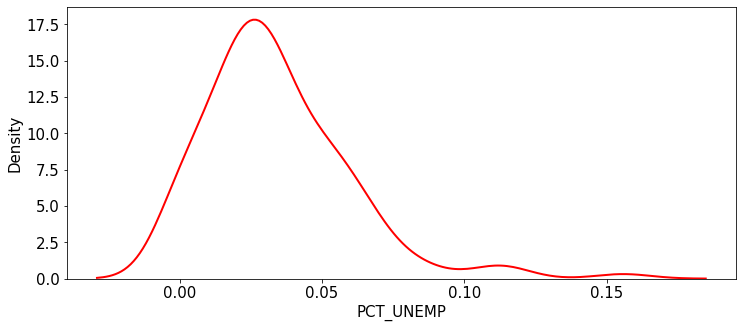

In [199]:
# Proportion of unemployed people
histogram_characteristics2([list(yes), list(yes_ces), list(yes_walkability)], bg_ces_df, 
                       ["Block Groups Within 1.5 \n Miles of Built Hub (Walking)", 
                       "[WITH CES]\n Block Groups Within 1.5 \n Miles of Built Hub (Walking)", 
                       "[WITH WALKABILITY]\n Block Groups Within 1.5 \n Miles of Built Hub (Walking)"],
                       'PCT_UNEMP',
                       ['red', 'green', 'orange']);

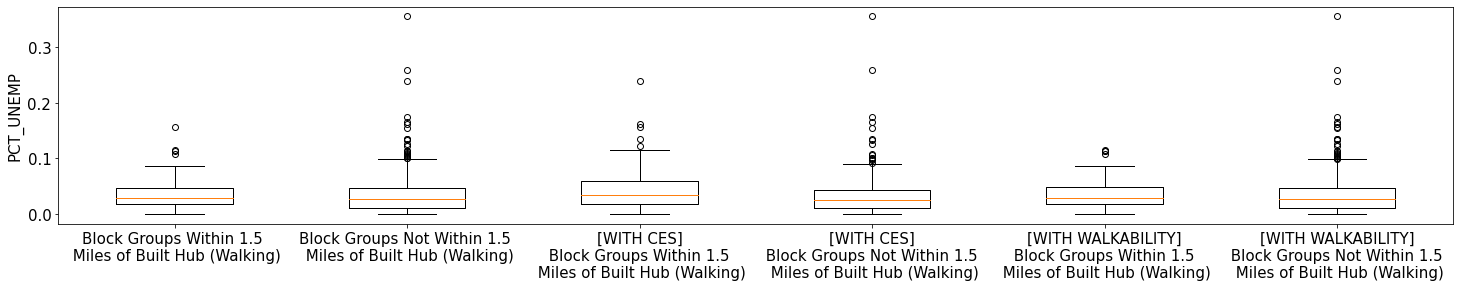

In [141]:
# Proportion of unemployed people
solve_models_functions_cmm.boxplot_characteristics([list(yes), list(no), list(yes_ces), list(no_ces), list(yes_walkability), list(no_walkability)], bg_ces_df, 
                       ["Block Groups Within 1.5 \n Miles of Built Hub (Walking)", 
                       "Block Groups Not Within 1.5 \n Miles of Built Hub (Walking)",
                       "[WITH CES]\n Block Groups Within 1.5 \n Miles of Built Hub (Walking)", 
                       "[WITH CES]\n Block Groups Not Within 1.5 \n Miles of Built Hub (Walking)",
                       "[WITH WALKABILITY]\n Block Groups Within 1.5 \n Miles of Built Hub (Walking)", 
                       "[WITH WALKABILITY]\n Block Groups Not Within 1.5 \n Miles of Built Hub (Walking)"],
                       'PCT_UNEMP');

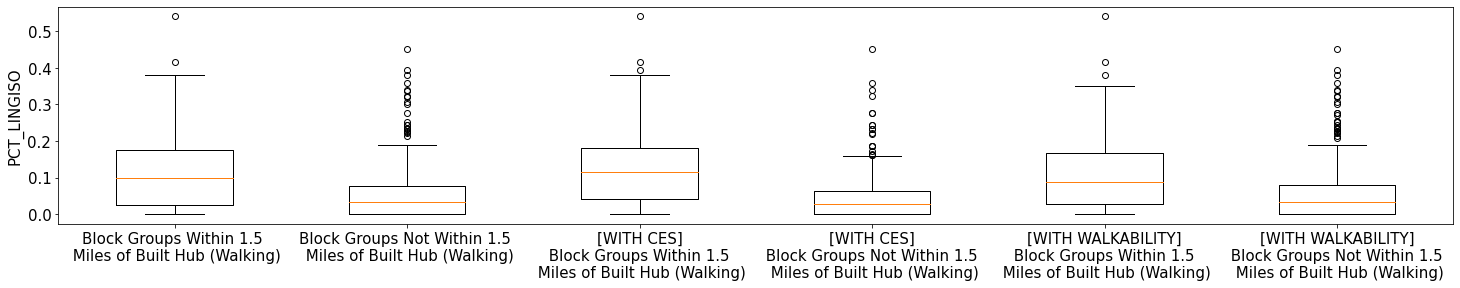

In [142]:
# Proportion of linguistically isolated people
solve_models_functions_cmm.boxplot_characteristics([list(yes), list(no), list(yes_ces), list(no_ces), list(yes_walkability), list(no_walkability)], bg_ces_df, 
                       ["Block Groups Within 1.5 \n Miles of Built Hub (Walking)", 
                       "Block Groups Not Within 1.5 \n Miles of Built Hub (Walking)",
                       "[WITH CES]\n Block Groups Within 1.5 \n Miles of Built Hub (Walking)", 
                       "[WITH CES]\n Block Groups Not Within 1.5 \n Miles of Built Hub (Walking)",
                       "[WITH WALKABILITY]\n Block Groups Within 1.5 \n Miles of Built Hub (Walking)", 
                       "[WITH WALKABILITY]\n Block Groups Not Within 1.5 \n Miles of Built Hub (Walking)"],
                       'PCT_LINGISO');

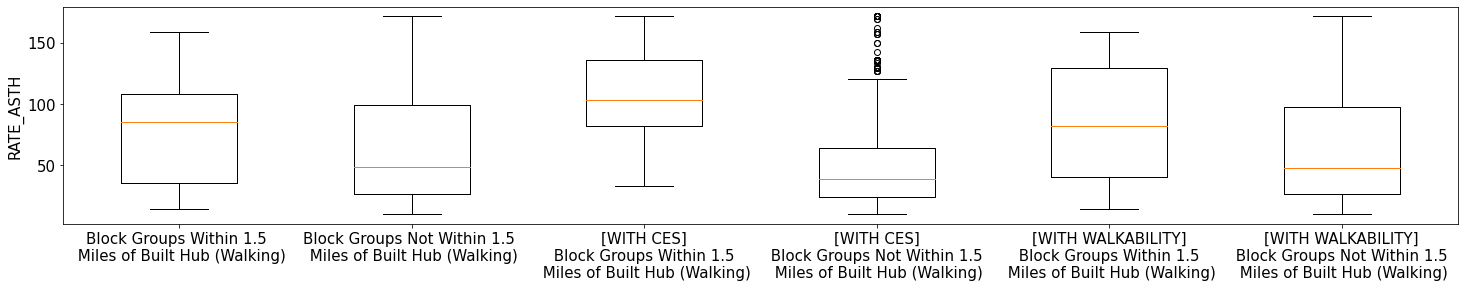

In [143]:
# Asthma Rate
solve_models_functions_cmm.boxplot_characteristics([list(yes), list(no), list(yes_ces), list(no_ces), list(yes_walkability), list(no_walkability)], bg_ces_df, 
                       ["Block Groups Within 1.5 \n Miles of Built Hub (Walking)", 
                       "Block Groups Not Within 1.5 \n Miles of Built Hub (Walking)",
                       "[WITH CES]\n Block Groups Within 1.5 \n Miles of Built Hub (Walking)", 
                       "[WITH CES]\n Block Groups Not Within 1.5 \n Miles of Built Hub (Walking)",
                       "[WITH WALKABILITY]\n Block Groups Within 1.5 \n Miles of Built Hub (Walking)", 
                       "[WITH WALKABILITY]\n Block Groups Not Within 1.5 \n Miles of Built Hub (Walking)"],
                       'RATE_ASTH');

In [148]:
plt.rcParams['figure.figsize'] = [10, 4]


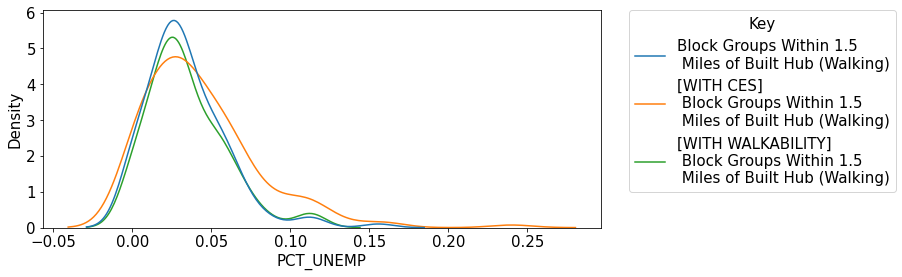

In [149]:
# Proportion of unemployed people
solve_models_functions_cmm.histogram_characteristics([list(yes), list(yes_ces), list(yes_walkability)], bg_ces_df, 
                       ["Block Groups Within 1.5 \n Miles of Built Hub (Walking)", 
                       "[WITH CES]\n Block Groups Within 1.5 \n Miles of Built Hub (Walking)", 
                       "[WITH WALKABILITY]\n Block Groups Within 1.5 \n Miles of Built Hub (Walking)"],
                       'PCT_UNEMP');

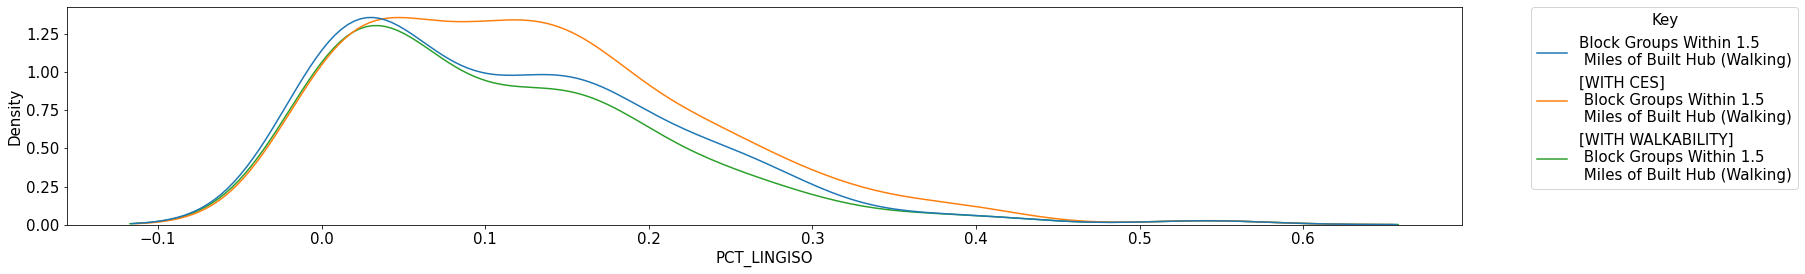

In [145]:
# Proportion of linguistically isolated people
solve_models_functions_cmm.histogram_characteristics([list(yes), list(yes_ces), list(yes_walkability)], bg_ces_df, 
                       ["Block Groups Within 1.5 \n Miles of Built Hub (Walking)", 
                       "[WITH CES]\n Block Groups Within 1.5 \n Miles of Built Hub (Walking)", 
                       "[WITH WALKABILITY]\n Block Groups Within 1.5 \n Miles of Built Hub (Walking)"],
                       'PCT_LINGISO');

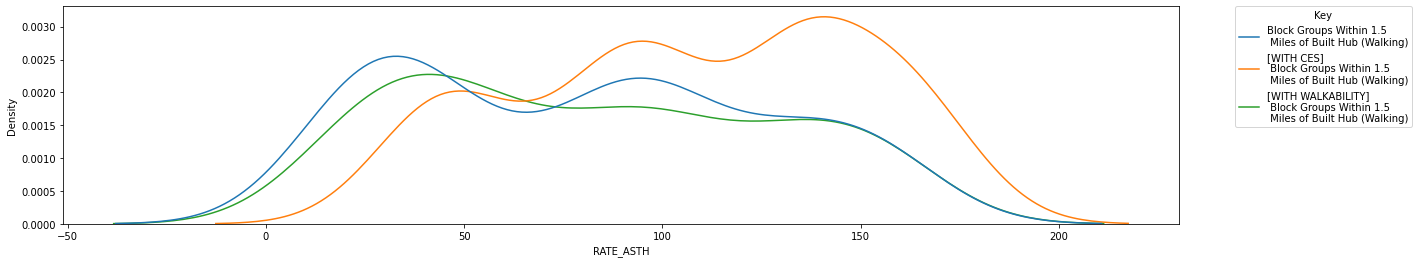

In [116]:
# Asthma Rate
solve_models_functions_cmm.histogram_characteristics([list(yes), list(yes_ces), list(yes_walkability)], bg_ces_df, 
                       ["Block Groups Within 1.5 \n Miles of Built Hub (Walking)", 
                       "[WITH CES]\n Block Groups Within 1.5 \n Miles of Built Hub (Walking)", 
                       "[WITH WALKABILITY]\n Block Groups Within 1.5 \n Miles of Built Hub (Walking)"],
                       'RATE_ASTH');

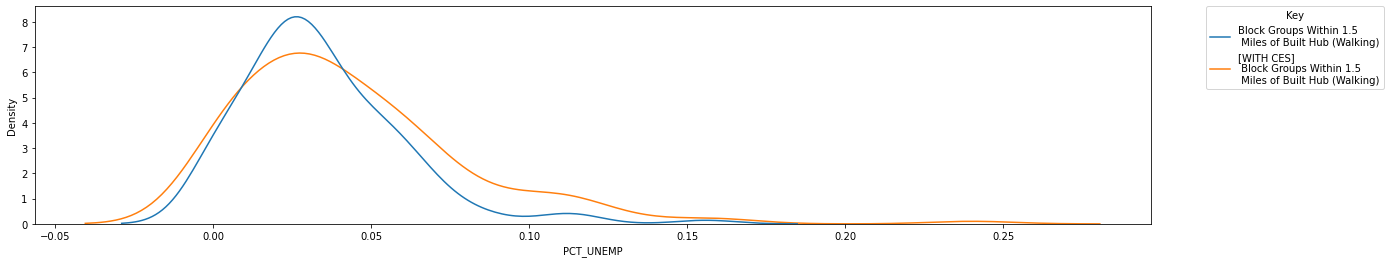

In [123]:
# Proportion of unemployed people
solve_models_functions_cmm.histogram_characteristics([list(yes), list(yes_ces)], bg_ces_df, 
                       ["Block Groups Within 1.5 \n Miles of Built Hub (Walking)", 
                       "[WITH CES]\n Block Groups Within 1.5 \n Miles of Built Hub (Walking)"],
                       'PCT_UNEMP');

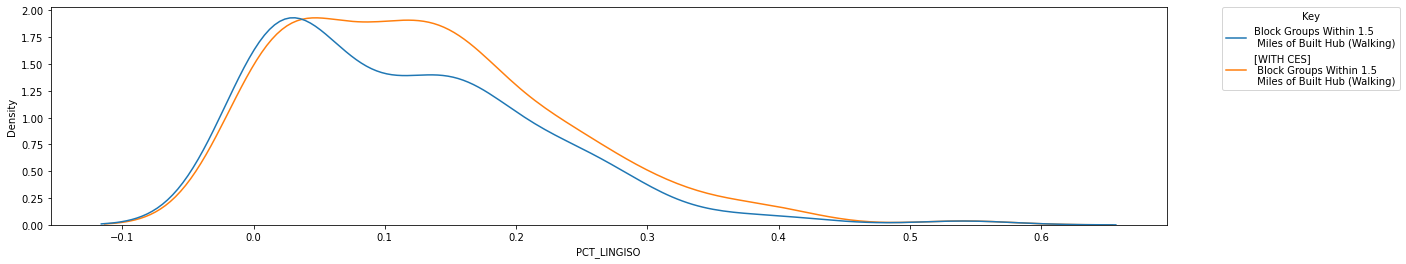

In [124]:
# Proportion of linguistically isolated people
solve_models_functions_cmm.histogram_characteristics([list(yes), list(yes_ces)], bg_ces_df, 
                       ["Block Groups Within 1.5 \n Miles of Built Hub (Walking)", 
                       "[WITH CES]\n Block Groups Within 1.5 \n Miles of Built Hub (Walking)"],
                       'PCT_LINGISO');

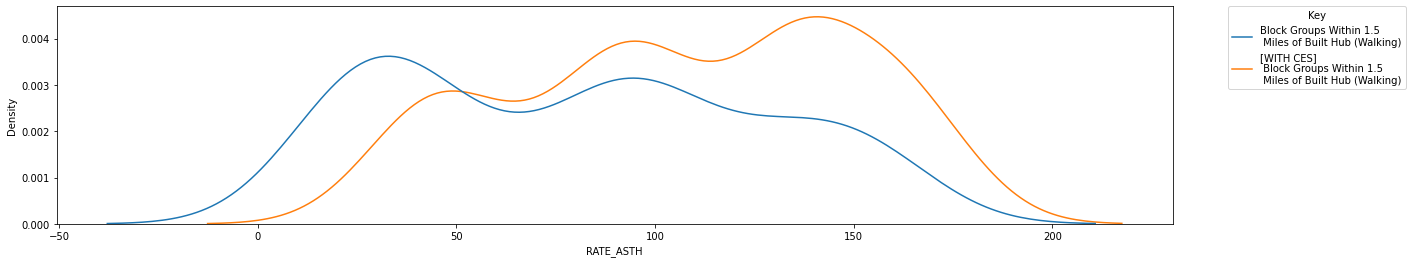

In [125]:
# Asthma Rate
solve_models_functions_cmm.histogram_characteristics([list(yes), list(yes_ces)], bg_ces_df, 
                       ["Block Groups Within 1.5 \n Miles of Built Hub (Walking)", 
                       "[WITH CES]\n Block Groups Within 1.5 \n Miles of Built Hub (Walking)"],
                       'RATE_ASTH');